In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 42
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

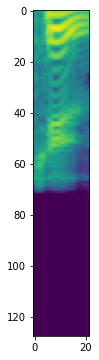

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
0.9759051536576493
TEST
loss: 0.5032872821695061
accuracy: 0.8387096774193549
******************
epoch: 1
Train
0.36651320282849303
TEST
loss: 0.31876174660139184
accuracy: 0.9075268817204301
******************
epoch: 2
Train
0.27632033073844353
TEST
loss: 0.47745771715717933
accuracy: 0.8666666666666667
******************
epoch: 3
Train
0.2590991300347677
TEST
loss: 0.5585552461685673
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.1872250047915073
TEST
loss: 0.4403208126544311
accuracy: 0.9032258064516129
******************
epoch: 5
Train
0.19104020516591233
TEST
loss: 0.5103915386302497
accuracy: 0.8494623655913979
******************
epoch: 6
Train
0.24451715993059536
TEST
loss: 0.18701068444918562
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.1634859050642629
TEST
loss: 0.43725476518113127
accuracy: 0.8709677419354839
******************
epoch: 8
Train
0.12008067485653205
TEST
loss: 0.22502502959261658
accuracy: 0.9376344086021505
*

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


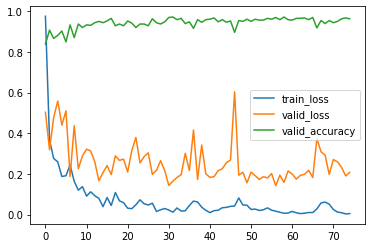

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0532608511117947
TEST
loss: 0.5914577853295111
accuracy: 0.8129032258064516
******************
epoch: 1
Train
0.39842403544876354
TEST
loss: 0.3254696725517191
accuracy: 0.8774193548387097
******************
epoch: 2
Train
0.3119702497732915
TEST
loss: 0.5014343782137799
accuracy: 0.8623655913978494
******************
epoch: 3
Train
0.2564853356452032
TEST
loss: 0.4079059994989826
accuracy: 0.864516129032258
******************
epoch: 4
Train
0.2043043304080275
TEST
loss: 0.34004994669268207
accuracy: 0.896774193548387
******************
epoch: 5
Train
0.1859199793735498
TEST
loss: 0.18655292539186374
accuracy: 0.946236559139785
******************
epoch: 6
Train
0.1637470775319481
TEST
loss: 0.2561447371077794
accuracy: 0.9225806451612903
******************
epoch: 7
Train
0.10685214420352242
TEST
loss: 0.21821431669817176
accuracy: 0.9311827956989247
******************
epoch: 8
Train
0.1638849485318508
TEST
loss: 0.3791883718582892
accuracy

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


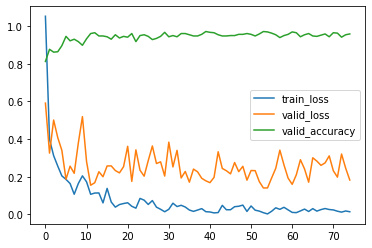

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.115085286354595
TEST
loss: 0.5495991428693136
accuracy: 0.8150537634408602
******************
epoch: 1
Train
0.4431932785206735
TEST
loss: 0.3996801004614881
accuracy: 0.8774193548387097
******************
epoch: 2
Train
0.3201676873539363
TEST
loss: 0.7653809003932501
accuracy: 0.8086021505376344
******************
epoch: 3
Train
0.3084293503753588
TEST
loss: 0.3674307612001255
accuracy: 0.9010752688172043
******************
epoch: 4
Train
0.25488784464701053
TEST
loss: 0.39668142000834145
accuracy: 0.8903225806451613
******************
epoch: 5
Train
0.21789161251896996
TEST
loss: 0.26018694498205697
accuracy: 0.9311827956989247
******************
epoch: 6
Train
0.1720744329045778
TEST
loss: 0.28568966516884425
accuracy: 0.9118279569892473
******************
epoch: 7
Train
0.16889381578806978
TEST
loss: 0.2849821893758671
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.18852964427179716
TEST
loss: 0.24146221590939387
acc

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


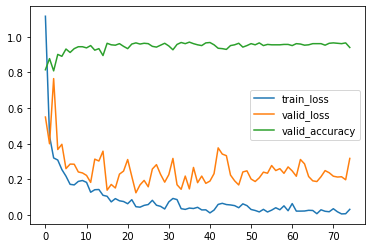

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0219995590327051
TEST
loss: 0.4473797226464877
accuracy: 0.8817204301075269
******************
epoch: 1
Train
0.3371442891316319
TEST
loss: 0.43825324671242827
accuracy: 0.8817204301075269
******************
epoch: 2
Train
0.267128126365752
TEST
loss: 0.42877462801112926
accuracy: 0.8623655913978494
******************
epoch: 3
Train
0.26131477777073314
TEST
loss: 0.740119235361776
accuracy: 0.7956989247311828
******************
epoch: 4
Train
0.21400081019248768
TEST
loss: 0.2668351250630553
accuracy: 0.9290322580645162
******************
epoch: 5
Train
0.18462628772904555
TEST
loss: 0.5667565052868218
accuracy: 0.8516129032258064
******************
epoch: 6
Train
0.1758371156328907
TEST
loss: 0.22005888137125199
accuracy: 0.9290322580645162
******************
epoch: 7
Train
0.14132998135055208
TEST
loss: 0.2988571704635697
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.12249952052781578
TEST
loss: 0.19175102024950008
acc

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


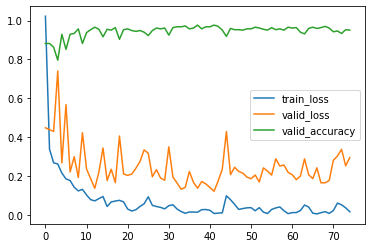

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
0.9171401893315806
TEST
loss: 0.7178970162586499
accuracy: 0.7763440860215054
******************
epoch: 1
Train
0.3516568259391723
TEST
loss: 0.40104907353719077
accuracy: 0.8731182795698925
******************
epoch: 2
Train
0.23285834252930612
TEST
loss: 0.23260190307453116
accuracy: 0.9333333333333333
******************
epoch: 3
Train
0.2255974643385789
TEST
loss: 0.30424927947341757
accuracy: 0.9247311827956989
******************
epoch: 4
Train
0.24830634650454833
TEST
loss: 0.4531272442110123
accuracy: 0.8838709677419355
******************
epoch: 5
Train
0.18875155400125712
TEST
loss: 0.18558864907551836
accuracy: 0.9483870967741935
******************
epoch: 6
Train
0.12868962959698854
TEST
loss: 0.25112932641660013
accuracy: 0.9204301075268817
******************
epoch: 7
Train
0.16301211427473933
TEST
loss: 0.2191264105379902
accuracy: 0.946236559139785
******************
epoch: 8
Train
0.12898510320570497
TEST
loss: 0.8026440678104277


In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9672977624784854


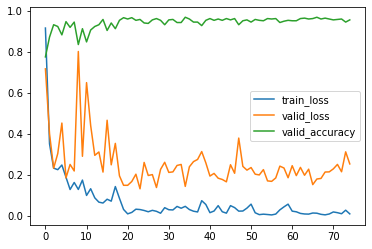

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0466759778763828
TEST
loss: 0.5040967085028207
accuracy: 0.843010752688172
******************
epoch: 1
Train
0.3890545491448127
TEST
loss: 0.2679418895834236
accuracy: 0.9096774193548387
******************
epoch: 2
Train
0.32123090980768076
TEST
loss: 0.39469165276455626
accuracy: 0.8924731182795699
******************
epoch: 3
Train
0.30491526741845415
TEST
loss: 0.3612072657513362
accuracy: 0.8989247311827957
******************
epoch: 4
Train
0.290901544727044
TEST
loss: 0.9273319716094642
accuracy: 0.7849462365591398
******************
epoch: 5
Train
0.20831133587327
TEST
loss: 0.3275143169587658
accuracy: 0.9161290322580645
******************
epoch: 6
Train
0.2024587359024622
TEST
loss: 0.16232786822703577
accuracy: 0.9483870967741935
******************
epoch: 7
Train
0.15609031843445798
TEST
loss: 0.15328472186160344
accuracy: 0.9591397849462365
******************
epoch: 8
Train
0.13451523275611602
TEST
loss: 0.37461776257522644
accura

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


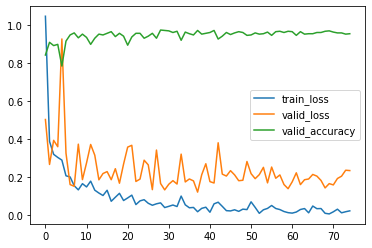

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.9575437539100133
TEST
loss: 1.333901914986231
accuracy: 0.5913978494623656
******************
epoch: 1
Train
1.360283740438565
TEST
loss: 1.0219724124477756
accuracy: 0.6688172043010753
******************
epoch: 2
Train
1.2403336500826225
TEST
loss: 0.8817168274233418
accuracy: 0.6838709677419355
******************
epoch: 3
Train
1.1500325106650062
TEST
loss: 0.5858537268894974
accuracy: 0.8365591397849462
******************
epoch: 4
Train
1.0959468439951596
TEST
loss: 0.2941073732991372
accuracy: 0.9075268817204301
******************
epoch: 5
Train
1.0776875361872413
TEST
loss: 0.9813187497918324
accuracy: 0.7333333333333333
******************
epoch: 6
Train
0.9985408356707136
TEST
loss: 0.4902965246990163
accuracy: 0.853763440860215
******************
epoch: 7
Train
0.9481755604844101
TEST
loss: 0.4353399060105765
accuracy: 0.8666666666666667
******************
epoch: 8
Train
0.8986504482337077
TEST
loss: 1.0597537958493797
accuracy: 0.7

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9518072289156626


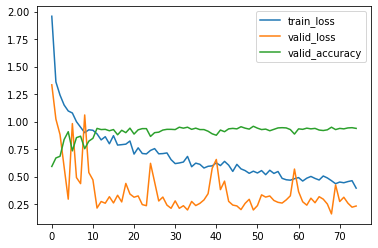

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.48248746219218
TEST
loss: 1.560821283248163
accuracy: 0.5032258064516129
******************
epoch: 1
Train
0.6791560671697975
TEST
loss: 1.736898180489899
accuracy: 0.5333333333333333
******************
epoch: 2
Train
0.4665337787498758
TEST
loss: 1.2671447419351147
accuracy: 0.5720430107526882
******************
epoch: 3
Train
0.41269060367528765
TEST
loss: 0.42417472780391735
accuracy: 0.8623655913978494
******************
epoch: 4
Train
0.3891410142038866
TEST
loss: 0.44716463262035
accuracy: 0.8709677419354839
******************
epoch: 5
Train
0.345069004632994
TEST
loss: 0.7710009836381482
accuracy: 0.7161290322580646
******************
epoch: 6
Train
0.3241165978457893
TEST
loss: 0.33097276347939686
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.2611443859053095
TEST
loss: 0.8696007838813208
accuracy: 0.7268817204301076
******************
epoch: 8
Train
0.24743990295987395
TEST
loss: 0.7635114233980896
accuracy: 0.8

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9259896729776248


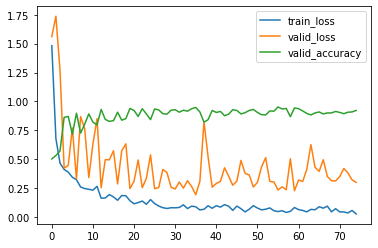

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.005838087571842
TEST
loss: 0.5847036284785117
accuracy: 0.8279569892473119
******************
epoch: 1
Train
0.3946672968795111
TEST
loss: 0.3029708582867858
accuracy: 0.9139784946236559
******************
epoch: 2
Train
0.2743864818227888
TEST
loss: 0.24065399375013125
accuracy: 0.9333333333333333
******************
epoch: 3
Train
0.20182259190641041
TEST
loss: 0.28152586535740926
accuracy: 0.9268817204301075
******************
epoch: 4
Train
0.2168871168655032
TEST
loss: 0.4043662541015174
accuracy: 0.8989247311827957
******************
epoch: 5
Train
0.22409935561186792
TEST
loss: 0.5589619248144089
accuracy: 0.8623655913978494
******************
epoch: 6
Train
0.21338742746739345
TEST
loss: 0.4644266487449728
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.15537121739513335
TEST
loss: 0.31877363266483427
accuracy: 0.9096774193548387
******************
epoch: 8
Train
0.16352826181957653
TEST
loss: 0.32585516565589495
ac

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


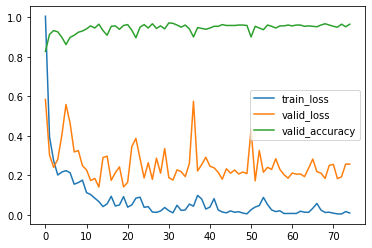

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0077002758484215
TEST
loss: 0.5590212409214307
accuracy: 0.832258064516129
******************
epoch: 1
Train
0.3624634154072743
TEST
loss: 0.6307381795298669
accuracy: 0.7849462365591398
******************
epoch: 2
Train
0.3088850417827879
TEST
loss: 0.7301558677868176
accuracy: 0.8172043010752689
******************
epoch: 3
Train
0.28810886285224135
TEST
loss: 0.288690502316721
accuracy: 0.9096774193548387
******************
epoch: 4
Train
0.1810623151147372
TEST
loss: 0.48245956743917157
accuracy: 0.853763440860215
******************
epoch: 5
Train
0.20407030169336013
TEST
loss: 0.42432443944997683
accuracy: 0.8989247311827957
******************
epoch: 6
Train
0.18713625116443275
TEST
loss: 0.3483363780603614
accuracy: 0.9268817204301075
******************
epoch: 7
Train
0.14390770167385178
TEST
loss: 0.2254148257035081
accuracy: 0.9483870967741935
******************
epoch: 8
Train
0.10296843473347657
TEST
loss: 0.21166236418229278
accur

In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


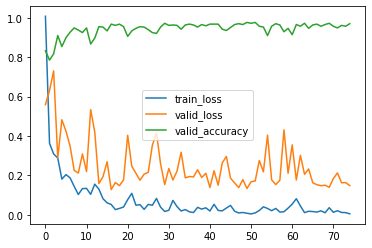

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0231071219498198
TEST
loss: 1.1900433248089206
accuracy: 0.7032258064516129
******************
epoch: 1
Train
0.43487727802545717
TEST
loss: 0.29418515098351306
accuracy: 0.896774193548387
******************
epoch: 2
Train
0.34304915285906484
TEST
loss: 0.8689493453630837
accuracy: 0.7913978494623656
******************
epoch: 3
Train
0.2797901791529946
TEST
loss: 0.30066217764090464
accuracy: 0.9139784946236559
******************
epoch: 4
Train
0.2677844646449492
TEST
loss: 0.2534948022615525
accuracy: 0.9139784946236559
******************
epoch: 5
Train
0.18661678591657854
TEST
loss: 0.17368884252444391
accuracy: 0.9376344086021505
******************
epoch: 6
Train
0.1922095821118188
TEST
loss: 0.47195050178035614
accuracy: 0.8774193548387097
******************
epoch: 7
Train
0.2071135646242831
TEST
loss: 0.30727525478409184
accuracy: 0.9139784946236559
******************
epoch: 8
Train
0.17614933217669534
TEST
loss: 0.260779484273285
acc

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


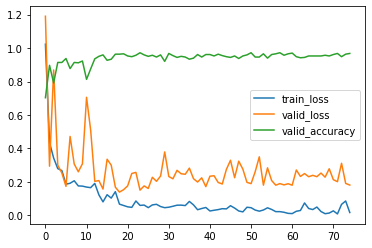

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
2.0294963345453185
TEST
loss: 1.4264469997857208
accuracy: 0.556989247311828
******************
epoch: 1
Train
1.4495560009760695
TEST
loss: 0.6943207345983033
accuracy: 0.7870967741935484
******************
epoch: 2
Train
1.2508075813741277
TEST
loss: 0.6789147625687302
accuracy: 0.7720430107526882
******************
epoch: 3
Train
1.2133325015465033
TEST
loss: 0.5729312445527763
accuracy: 0.810752688172043
******************
epoch: 4
Train
1.1119600699419094
TEST
loss: 0.5010057048451516
accuracy: 0.8387096774193549
******************
epoch: 5
Train
1.0938280847166326
TEST
loss: 0.344899038281492
accuracy: 0.8881720430107527
******************
epoch: 6
Train
1.0268402623436947
TEST
loss: 0.3568488186085096
accuracy: 0.8666666666666667
******************
epoch: 7
Train
0.973914148862733
TEST
loss: 0.4011246112085158
accuracy: 0.8838709677419355
******************
epoch: 8
Train
0.9523902687900607
TEST
loss: 0.5092537064706125
accuracy: 0.85

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


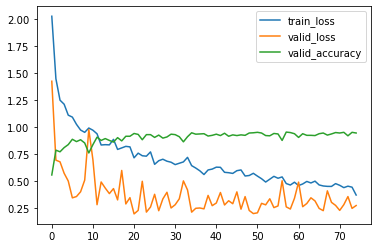

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0262470000138126
TEST
loss: 1.377368297371813
accuracy: 0.6688172043010753
******************
epoch: 1
Train
0.45102929735158037
TEST
loss: 0.3272683931935218
accuracy: 0.9053763440860215
******************
epoch: 2
Train
0.2804133067159288
TEST
loss: 0.34230339270766064
accuracy: 0.8881720430107527
******************
epoch: 3
Train
0.2585683027197099
TEST
loss: 0.42987300301751785
accuracy: 0.8817204301075269
******************
epoch: 4
Train
0.2810880796332865
TEST
loss: 0.34647240292641424
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.23945425060017492
TEST
loss: 0.2395317926842679
accuracy: 0.9333333333333333
******************
epoch: 6
Train
0.18305268005844594
TEST
loss: 0.7232961041952974
accuracy: 0.8258064516129032
******************
epoch: 7
Train
0.1839288685934224
TEST
loss: 0.2793550685769127
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.1577837610668435
TEST
loss: 0.2375655773025687
accur

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


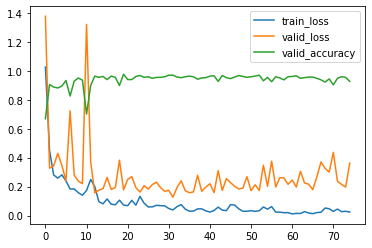

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.906617817727224
TEST
loss: 1.7831272299571703
accuracy: 0.5376344086021505
******************
epoch: 1
Train
1.3586431803983197
TEST
loss: 0.5861796634171599
accuracy: 0.7956989247311828
******************
epoch: 2
Train
1.2192863840278785
TEST
loss: 0.6913286261661078
accuracy: 0.7741935483870968
******************
epoch: 3
Train
1.1359402490162889
TEST
loss: 0.6841487405120685
accuracy: 0.789247311827957
******************
epoch: 4
Train
1.055307865913157
TEST
loss: 0.6552781168491609
accuracy: 0.8129032258064516
******************
epoch: 5
Train
1.1038658434046682
TEST
loss: 0.3674630190736504
accuracy: 0.8688172043010752
******************
epoch: 6
Train
0.9911823574419489
TEST
loss: 0.2863253329389839
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.9359996814399107
TEST
loss: 0.3353621321339761
accuracy: 0.886021505376344
******************
epoch: 8
Train
0.9353614568581938
TEST
loss: 1.9187096826491816
accuracy: 0.69

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


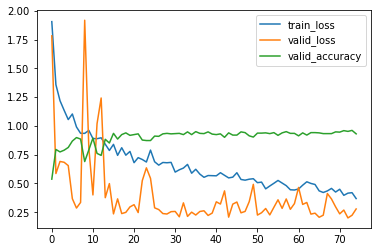

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0024423056157226
TEST
loss: 0.5163549690477309
accuracy: 0.8516129032258064
******************
epoch: 1
Train
0.392814031517756
TEST
loss: 0.29516945039072345
accuracy: 0.9161290322580645
******************
epoch: 2
Train
0.2571817172363232
TEST
loss: 0.24824391725242778
accuracy: 0.9397849462365592
******************
epoch: 3
Train
0.19037806194959692
TEST
loss: 0.34048098498775115
accuracy: 0.896774193548387
******************
epoch: 4
Train
0.2147944131780839
TEST
loss: 0.7100867281036992
accuracy: 0.8301075268817204
******************
epoch: 5
Train
0.18192095670189085
TEST
loss: 0.5863311613759686
accuracy: 0.8817204301075269
******************
epoch: 6
Train
0.20587256173645865
TEST
loss: 0.3175684477052381
accuracy: 0.9075268817204301
******************
epoch: 7
Train
0.15400327767777583
TEST
loss: 0.37612584508875363
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.1381064688382639
TEST
loss: 0.41745022246914526
accu

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


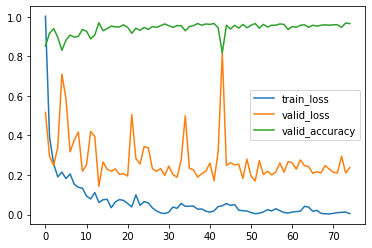

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0379436136126583
TEST
loss: 0.6542046249553721
accuracy: 0.8236559139784946
******************
epoch: 1
Train
0.46696911156017035
TEST
loss: 0.4648152382143082
accuracy: 0.8709677419354839
******************
epoch: 2
Train
0.3047859433779616
TEST
loss: 0.3253202180708608
accuracy: 0.8924731182795699
******************
epoch: 3
Train
0.2943916542913943
TEST
loss: 0.28526289985384995
accuracy: 0.9204301075268817
******************
epoch: 4
Train
0.293571538994501
TEST
loss: 0.4416543791371007
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.23528287416513594
TEST
loss: 0.2412897639697598
accuracy: 0.9376344086021505
******************
epoch: 6
Train
0.17504772468478563
TEST
loss: 0.19808901737454118
accuracy: 0.9483870967741935
******************
epoch: 7
Train
0.15995718396730685
TEST
loss: 0.2760745302323372
accuracy: 0.9505376344086022
******************
epoch: 8
Train
0.16955894937936375
TEST
loss: 0.28547541338910337
acc

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


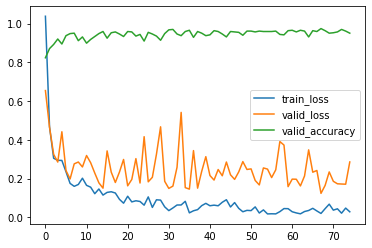

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0208090141247086
TEST
loss: 0.5988038300186075
accuracy: 0.8150537634408602
******************
epoch: 1
Train
0.364127395868173
TEST
loss: 0.37325526556020144
accuracy: 0.8774193548387097
******************
epoch: 2
Train
0.27131515545554874
TEST
loss: 0.3608595762842445
accuracy: 0.8989247311827957
******************
epoch: 3
Train
0.24972170369883154
TEST
loss: 0.5832525437878024
accuracy: 0.8451612903225807
******************
epoch: 4
Train
0.23583822272513333
TEST
loss: 0.703082428696335
accuracy: 0.8516129032258064
******************
epoch: 5
Train
0.16046627755760826
TEST
loss: 0.5490010840918428
accuracy: 0.8666666666666667
******************
epoch: 6
Train
0.16943321923896326
TEST
loss: 0.2890765861477903
accuracy: 0.9376344086021505
******************
epoch: 7
Train
0.12057589507257033
TEST
loss: 0.2929316762314048
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.09222768375516643
TEST
loss: 0.7996637111709964
accu

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


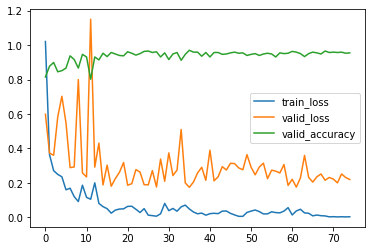

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0941471981629929
TEST
loss: 1.0669827389460738
accuracy: 0.7526881720430108
******************
epoch: 1
Train
0.474349129373307
TEST
loss: 0.5171902164336174
accuracy: 0.8559139784946237
******************
epoch: 2
Train
0.3266900892725027
TEST
loss: 0.39143183026262507
accuracy: 0.875268817204301
******************
epoch: 3
Train
0.2978047390554179
TEST
loss: 0.5298583531171404
accuracy: 0.8623655913978494
******************
epoch: 4
Train
0.23355765136005935
TEST
loss: 0.2754739713925187
accuracy: 0.9075268817204301
******************
epoch: 5
Train
0.20778196324696127
TEST
loss: 0.3473103789712793
accuracy: 0.9096774193548387
******************
epoch: 6
Train
0.21422260985235791
TEST
loss: 0.2317033943950489
accuracy: 0.9419354838709677
******************
epoch: 7
Train
0.17866856678237053
TEST
loss: 0.20921099141079894
accuracy: 0.9311827956989247
******************
epoch: 8
Train
0.1475188061314112
TEST
loss: 0.4344534349697892
accura

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9586919104991394


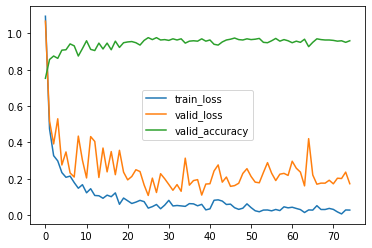

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.0726086787787188
TEST
loss: 0.48068091856536044
accuracy: 0.8602150537634409
******************
epoch: 1
Train
0.3892980507772073
TEST
loss: 0.28759616427524115
accuracy: 0.9032258064516129
******************
epoch: 2
Train
0.25157930588426936
TEST
loss: 0.26815051899481845
accuracy: 0.9225806451612903
******************
epoch: 3
Train
0.2311181900125071
TEST
loss: 0.5385595897192597
accuracy: 0.8881720430107527
******************
epoch: 4
Train
0.2520226996369945
TEST
loss: 0.4615881335350775
accuracy: 0.8795698924731182
******************
epoch: 5
Train
0.2013820526929844
TEST
loss: 0.32154388171370313
accuracy: 0.9161290322580645
******************
epoch: 6
Train
0.20218904248218608
TEST
loss: 0.3032948703214686
accuracy: 0.9204301075268817
******************
epoch: 7
Train
0.12356822578638679
TEST
loss: 0.2853790488294376
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.14762144394953147
TEST
loss: 0.35174898383437947
a

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9655765920826161


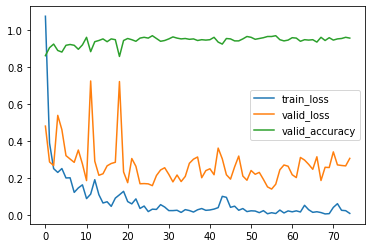

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 42
epoch: 0
Train
1.3253062014048242
TEST
loss: 0.7506085120221619
accuracy: 0.7526881720430108
******************
epoch: 1
Train
0.5593868642323236
TEST
loss: 0.44579016803413307
accuracy: 0.8516129032258064
******************
epoch: 2
Train
0.44199237119914
TEST
loss: 0.29400304709711383
accuracy: 0.9010752688172043
******************
epoch: 3
Train
0.3644050880343797
TEST
loss: 0.28652148435833635
accuracy: 0.9161290322580645
******************
epoch: 4
Train
0.31813760033588484
TEST
loss: 0.3043855413313835
accuracy: 0.9161290322580645
******************
epoch: 5
Train
0.2980412644407861
TEST
loss: 1.099348416892431
accuracy: 0.7311827956989247
******************
epoch: 6
Train
0.31777265582857556
TEST
loss: 0.25277878722195984
accuracy: 0.9354838709677419
******************
epoch: 7
Train
0.27577122431258455
TEST
loss: 0.505146009563118
accuracy: 0.8494623655913979
******************
epoch: 8
Train
0.23553677085399885
TEST
loss: 0.17273669215620205
accur

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


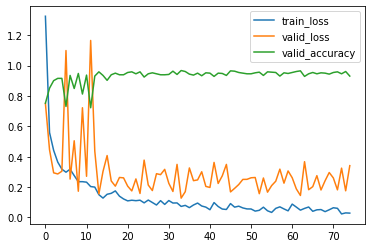

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()